In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, Voronoi
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import Voronoi, voronoi_plot_2d

In [62]:
grid_map  = np.loadtxt("grid_map3.txt", dtype=float)

In [63]:
obstacle_coords = np.argwhere(grid_map == 1)
obstacle_points = np.array([[(x[0] + 0.5), (x[1] + 0.5)] for x in obstacle_coords])

In [64]:
tri = Delaunay(obstacle_points)

vor = Voronoi(obstacle_points)

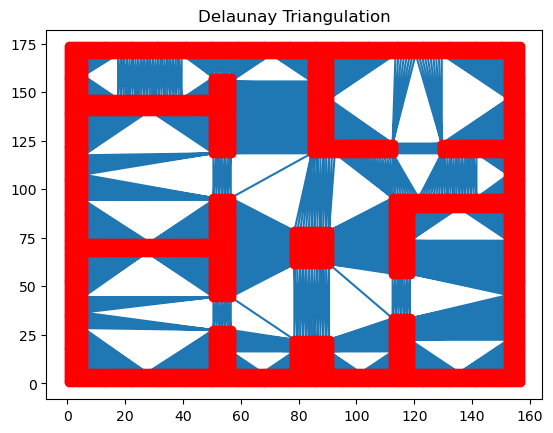

In [ ]:
# Visualize Delaunay triangulation
plt.figure()
plt.triplot(obstacle_points[:, 0], obstacle_points[:, 1], tri.simplices)
plt.plot(obstacle_points[:, 0], obstacle_points[:, 1], 'ro') 
plt.title('Delaunay Triangulation')
plt.show()

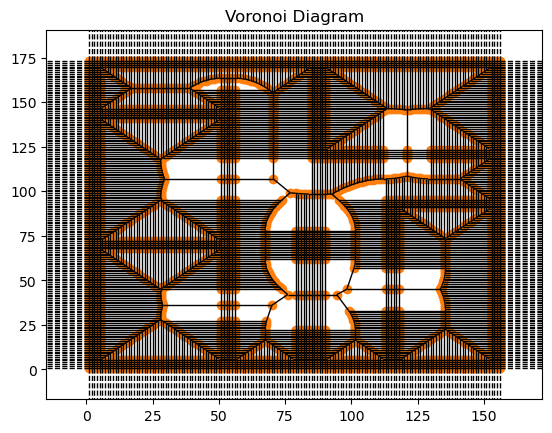

In [66]:
fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)
ax.set_title('Voronoi Diagram')
plt.show()

In [ ]:
def create_adjacency_matrix(vor):
    num_vertices = len(vor.vertices)
    
    # Initialize adjacency matrix
    adjacency_matrix = np.zeros((num_vertices, num_vertices))

    # Traverse all Voronoi edges
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # Skip infinite edges
        i, j = ridge
        distance = np.linalg.norm(vor.vertices[i] - vor.vertices[j])

        # Fill adjacency matrix
        adjacency_matrix[i, j] = distance
        adjacency_matrix[j, i] = distance  # Symmetric fill

    return adjacency_matrix

# Create adjacency matrix
adjacency_matrix = create_adjacency_matrix(vor)
print("\nAdjacency Matrix:\n", adjacency_matrix)
print(adjacency_matrix.shape)


Adjacency Matrix:
 [[0.         8.48528137 0.         ... 0.         0.         0.        ]
 [8.48528137 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 1.         1.         0.        ]]
(6437, 6437)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot(vor, valid_vertices=None, new_adjacency_matrix=None, vertex_map=None, show=False, tpath=[-1], Apath=[-1], show_Ipath=False, show_Apath=False):
    # If valid_vertices is not provided, default to using all vertices in vor.vertices
    if valid_vertices is None:
        valid_vertices = list(range(len(vor.vertices)))
    
    # If new_adjacency_matrix is not provided, build a complete adjacency matrix based on vor.ridge_vertices
    if new_adjacency_matrix is None:
        num_vertices = len(vor.vertices)
        new_adjacency_matrix = np.zeros((num_vertices, num_vertices), dtype=float)
        
        # Build complete adjacency matrix based on vor.ridge_vertices
        for ridge in vor.ridge_vertices:
            if -1 in ridge:
                continue  # Skip infinite edges
            i, j = ridge
            distance = np.linalg.norm(vor.vertices[i] - vor.vertices[j])
            new_adjacency_matrix[i, j] = distance
            new_adjacency_matrix[j, i] = distance  # Symmetric fill

    # If vertex_map is not provided, create an identity mapping assuming all vertices are valid
    if vertex_map is None:
        vertex_map = {i: i for i in valid_vertices}

    # Create plot area
    fig, ax = plt.subplots(figsize=(12, 8))  # Set appropriate size
    reverse_vertex_map = {v: k for k, v in vertex_map.items()}

    # Draw valid Voronoi edges
    for i in range(new_adjacency_matrix.shape[0]):
        for j in range(i + 1, new_adjacency_matrix.shape[1]):
            if new_adjacency_matrix[i, j] > 0:  # If there is a connection between two valid vertices
                # Use reverse_vertex_map to map new indices back to original vertex indices
                original_i = reverse_vertex_map[i]
                original_j = reverse_vertex_map[j]
                # Draw edges using original vertex coordinates
                ax.plot([vor.vertices[original_i][1], vor.vertices[original_j][1]],
                        [vor.vertices[original_i][0], vor.vertices[original_j][0]],
                        color='blue', linewidth=0.8)

    # Draw filtered Voronoi points (green)
    filtered_vertices = vor.vertices[valid_vertices]
    ax.plot(filtered_vertices[:, 1], filtered_vertices[:, 0], 'o', color='green', label='Filtered Voronoi Points', markersize=4)

    # Draw key nodes
    if tpath[0] != -1:
        important_vertices = []
        for i in tpath:
            t_tans = [k for k, v in vertex_map.items() if v == i]
            if t_tans:  # Ensure a matching index is found
                triple = vor.vertices[t_tans[0]]  # Use the first matching index
                important_vertices.append(triple)  # Add to important vertices list
        important_vertices = np.array(important_vertices)
        ax.plot(important_vertices[:, 1], important_vertices[:, 0], 'o', color='red', label='Important Voronoi Points', markersize=4)

    # Draw A* path
    if show_Apath and Apath[0] != -1:
        for i in range(len(Apath) - 1):
            start_idx = valid_vertices[Apath[i]]
            end_idx = valid_vertices[Apath[i + 1]]
            start = vor.vertices[start_idx]
            end = vor.vertices[end_idx]
            ax.plot([start[1], end[1]], [start[0], end[0]], color='pink', linewidth=2, label='Astar Path' if i == 0 else "")

    # Draw key path
    if show_Ipath and tpath[0] != -1:
        for i in range(len(tpath) - 1):
            start_idx = valid_vertices[tpath[i]]
            end_idx = valid_vertices[tpath[i + 1]]
            start = vor.vertices[start_idx]
            end = vor.vertices[end_idx]
            ax.plot([start[1], end[1]], [start[0], end[0]], color='red', linewidth=2, label='Key Path' if i == 0 else "")

    # Display index in vor.vertices for each green point
    if show:
        for idx in valid_vertices:
            vertex = vor.vertices[idx]
            ax.text(vertex[1], vertex[0], str(idx), fontsize=8, ha='center', color='purple')

    # Draw obstacle squares
    if obstacle_points is not None:
        for obstacle in obstacle_points:
            ax.add_patch(plt.Rectangle((obstacle[1] - 0.5, obstacle[0] - 0.5), 1, 1, color='black'))

    # Set axis range
    ax.set_xlim(-0.1, grid_map.shape[1] + 0.1)
    ax.set_ylim(-0.1, grid_map.shape[0] + 0.1)

    # Set title and labels
    ax.set_title("Path planning based on the Voronoi skeleton", fontsize=16)
    ax.set_xlabel("X Coordinate", fontsize=12)
    ax.set_ylabel("Y Coordinate", fontsize=12)

    # Adjust legend position to display outside the plot
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Adjust layout to prevent clipping
    plt.tight_layout()

    # Show plot
    plt.show()

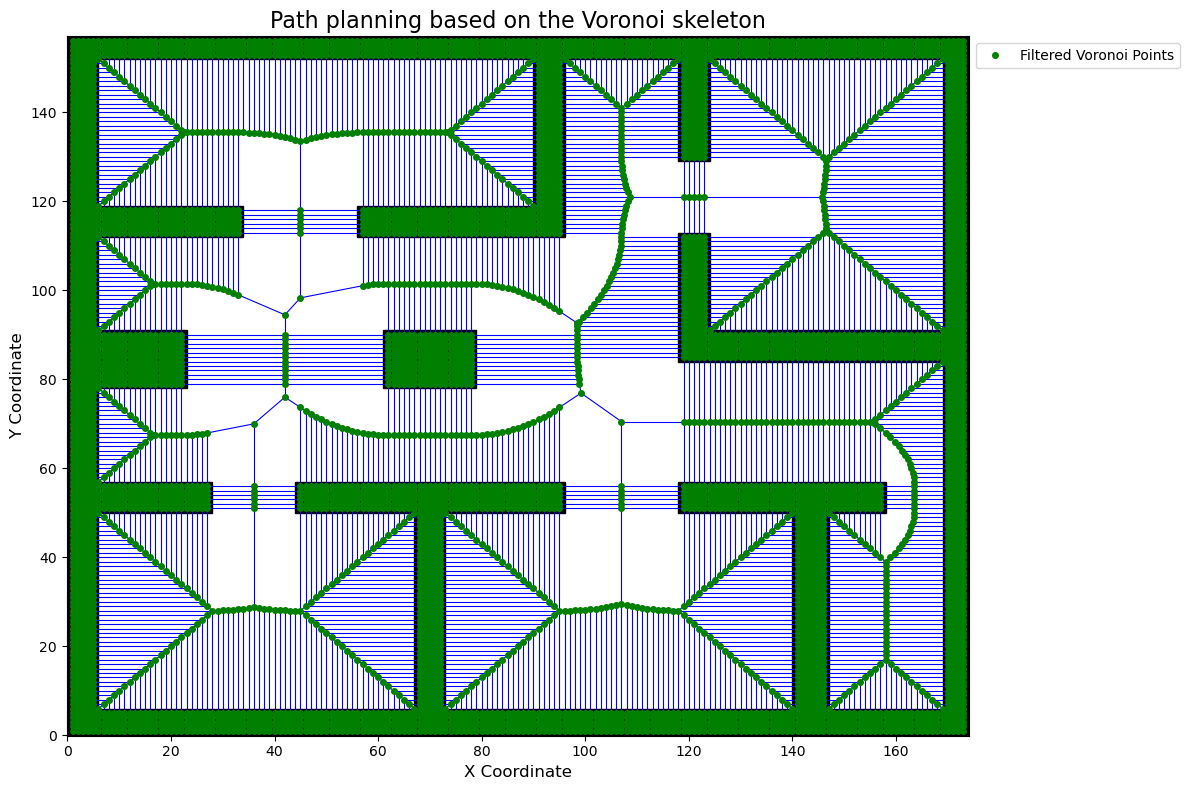

In [69]:
plot(vor)

In [70]:
m_xl = 0
m_yl = 0
resolution = 1
threshold = np.sqrt(2) / 2 * resolution

In [71]:
def convert_to_grid_coordinates(x, y, m_xl, m_yl, resolution):
    x_g = int(np.floor((x - m_xl) / resolution))
    y_g = int(np.floor((y - m_yl) / resolution))
    return x_g, y_g

In [ ]:
def filter_obstacle_vertices3(vor, grid_map, m_xl, m_yl, resolution):
    valid_vertices = []
    vertex_map = {}

    # Find all valid vertices and create a mapping
    for i, vertex in enumerate(vor.vertices):
        x_g, y_g = convert_to_grid_coordinates(vertex[0], vertex[1], m_xl, m_yl, resolution)
        # Check if the vertex is inside an obstacle
        if (0 <= x_g < grid_map.shape[0] and 0 <= y_g < grid_map.shape[1]) and grid_map[x_g, y_g] != 1:
            vertex_map[i] = len(valid_vertices)  # Map original index to new valid index
            valid_vertices.append(i)  # Keep vertices not inside obstacles

    # Create new adjacency matrix containing only valid vertices
    num_valid_vertices = len(valid_vertices)
    new_adjacency_matrix = np.zeros((num_valid_vertices, num_valid_vertices), dtype=float)

    # Traverse all Voronoi edges, keeping only edges between valid vertices
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # Skip infinite edges

        i, j = ridge  # Get the indices of the two vertices of the edge
        if i in vertex_map and j in vertex_map:  # Keep the edge only when both vertices are valid
            new_i = vertex_map[i]
            new_j = vertex_map[j]
            # Calculate distance between two valid vertices
            distance = np.linalg.norm(vor.vertices[i] - vor.vertices[j])
            new_adjacency_matrix[new_i, new_j] = distance
            new_adjacency_matrix[new_j, new_i] = distance  # Symmetric fill

    # Return valid vertex indices, new adjacency matrix, and mapping from original to valid indices
    return valid_vertices, new_adjacency_matrix, vertex_map

In [ ]:
valid_vertices, filtered_adjacency_matrix, vertex_map = filter_obstacle_vertices3(vor, grid_map, m_xl, m_yl, resolution)

print("Valid vertex indices:", valid_vertices)
print("Filtered adjacency matrix:\n", filtered_adjacency_matrix)
print("Filtered adjacency matrix size:\n", filtered_adjacency_matrix.shape)
print("Mapping from original to valid indices:\n", vertex_map)

有效顶点索引: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 46, 47, 48, 49, 50, 53, 54, 55, 57, 58, 59, 60, 61, 62, 63, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 86, 87, 88, 90, 91, 92, 100, 102, 105, 107, 108, 109, 117, 119, 120, 123, 124, 136, 137, 138, 145, 146, 148, 149, 150, 152, 155, 156, 157, 158, 159, 160, 161, 168, 169, 170, 171, 172, 173, 176, 180, 181, 185, 186, 191, 192, 195, 206, 207, 208, 209, 220, 222, 223, 228, 229, 230, 234, 236, 240, 241, 242, 243, 246, 256, 257, 258, 260, 261, 263, 264, 268, 269, 270, 271, 272, 273, 277, 278, 296, 299, 300, 301, 302, 305, 306, 307, 308, 309, 310, 311, 316, 317, 323, 335, 336, 337, 338, 342, 343, 344, 345, 346, 347, 348, 349, 357, 358, 359, 361, 362, 369, 373, 374, 385, 390, 391, 398, 399, 430, 431, 432, 439, 441, 442, 448, 449, 454, 455, 457, 458, 461, 462, 480, 481, 485, 486, 492, 493, 500, 501, 505, 506, 508, 509, 521, 532, 533, 544, 545, 546, 549, 550, 556, 

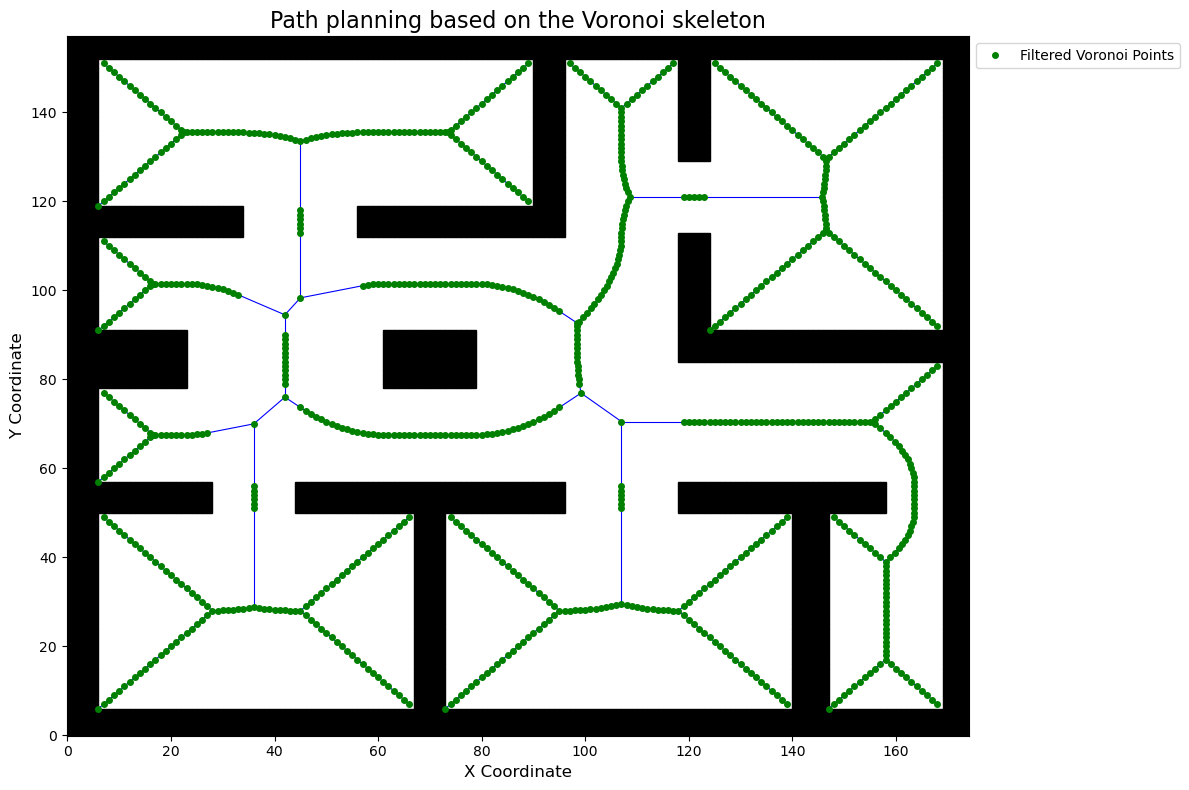

In [74]:
plot(vor,valid_vertices,filtered_adjacency_matrix,vertex_map)

In [ ]:
def filter_voronoi_edges1(vor, grid_map, vertex_map, resolution, threshold):
    num_valid_vertices = len(vertex_map)
    updated_adjacency_matrix = np.zeros((num_valid_vertices, num_valid_vertices), dtype=float)
    
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # Skip infinite edges
        
        i, j = ridge
        if i in vertex_map and j in vertex_map:
            p1, p2 = vor.vertices[i], vor.vertices[j]
            d_obs_min = float('inf')
            
            # Find the minimum grid range containing this edge
            min_x, max_x = int(np.floor(min(p1[0], p2[0]) / resolution)), int(np.ceil(max(p1[0], p2[0]) / resolution))
            min_y, max_y = int(np.floor(min(p1[1], p2[1]) / resolution)), int(np.ceil(max(p1[1], p2[1]) / resolution))
        
            # Calculate minimum distance from each obstacle center to the edge
            for y in range(min_y, max_y + 1):
                for x in range(min_x, max_x + 1):
                    if grid_map[x, y] == 1:  # Obstacle grid
                        p_i = np.array([(x + 0.5) * resolution, (y + 0.5) * resolution])
                        d_obs = np.abs(np.linalg.det([p2 - p1, p_i - p1]) / np.linalg.norm(p2 - p1))
                        d_obs_min = min(d_obs_min, d_obs)
            # Check if minimum distance exceeds threshold
            if d_obs_min >= threshold:
                new_i = vertex_map[i]
                new_j = vertex_map[j]
                distance = np.linalg.norm(p1 - p2)
                updated_adjacency_matrix[new_i, new_j] = distance
                updated_adjacency_matrix[new_j, new_i] = distance  # Symmetric fill
                
    return updated_adjacency_matrix

In [ ]:
def filter_voronoi_edges(vor, grid_map, vertex_map, resolution, threshold):
    num_valid_vertices = len(vertex_map)
    updated_adjacency_matrix = np.zeros((num_valid_vertices, num_valid_vertices), dtype=float)
    
    for ridge in vor.ridge_vertices:
        if -1 in ridge:
            continue  # Skip infinite edges
        
        i, j = ridge
        if i in vertex_map and j in vertex_map:
            p1, p2 = vor.vertices[i], vor.vertices[j]
            edge_crosses_obstacle = False  # Flag indicating if edge crosses an obstacle
            
            # Find the minimum grid range containing this edge
            min_x, max_x = int(np.floor(min(p1[0], p2[0]) / resolution)), int(np.ceil(max(p1[0], p2[0]) / resolution))
            min_y, max_y = int(np.floor(min(p1[1], p2[1]) / resolution)), int(np.ceil(max(p1[1], p2[1]) / resolution))
        
            # Check if this edge crosses through obstacles
            for y in range(min_y, max_y + 1):
                for x in range(min_x, max_x + 1):
                    if grid_map[x, y] == 1:  # Obstacle grid
                        # Calculate distance from obstacle center to edge
                        p_i = np.array([(x + 0.5) * resolution, (y + 0.5) * resolution])
                        d_obs = np.abs(np.linalg.det([p2 - p1, p_i - p1]) / np.linalg.norm(p2 - p1))
                        
                        # If distance is less than a certain value, consider edge crosses obstacle
                        if d_obs < threshold - 0.1:
                            edge_crosses_obstacle = True
                            break
                if edge_crosses_obstacle:
                    break
            
            # If edge doesn't cross any obstacle, add it to adjacency matrix
            if not edge_crosses_obstacle:
                new_i = vertex_map[i]
                new_j = vertex_map[j]
                distance = np.linalg.norm(p1 - p2)
                updated_adjacency_matrix[new_i, new_j] = distance
                updated_adjacency_matrix[new_j, new_i] = distance  # Symmetric fill
                
    return updated_adjacency_matrix

In [77]:
updated_adjacency_matrix = filter_voronoi_edges(vor,grid_map,vertex_map,resolution,threshold)
print(updated_adjacency_matrix.shape)
np.savetxt("updated_adjacency_matrix.txt", updated_adjacency_matrix, fmt="%f", delimiter=" ")

(860, 860)


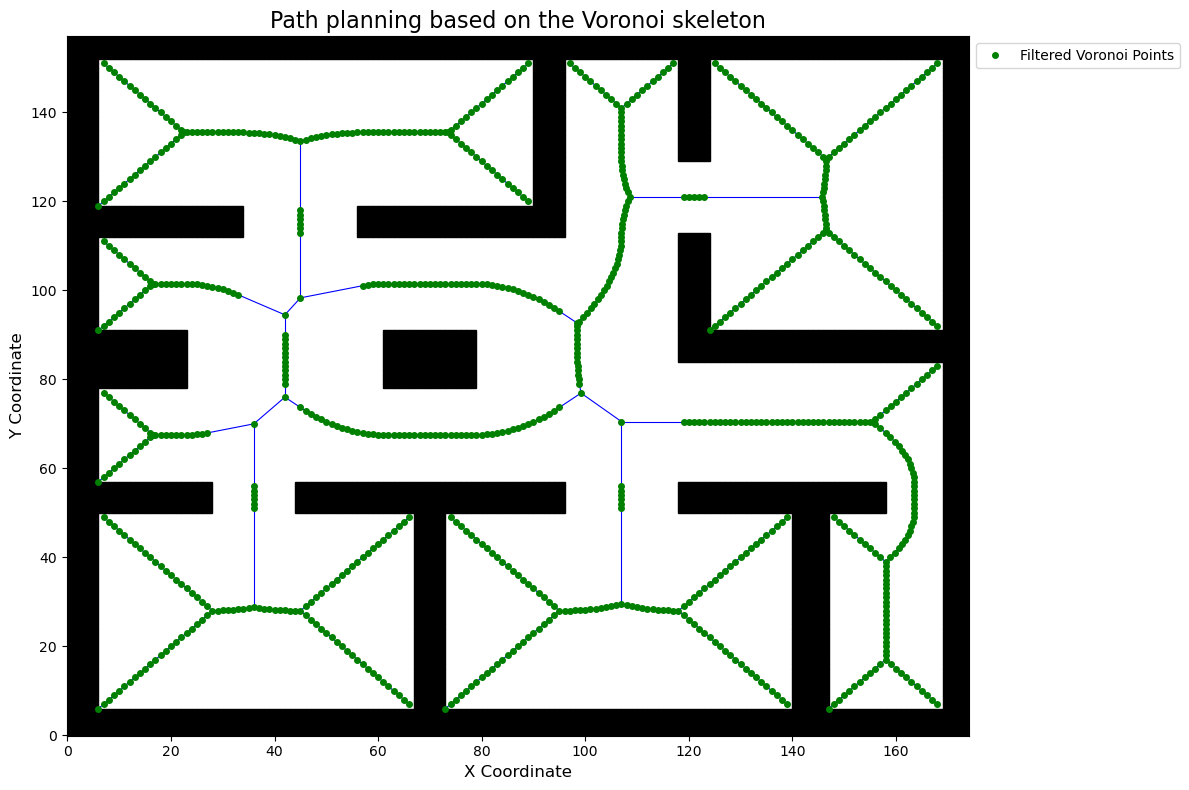

In [78]:
plot(vor,valid_vertices,updated_adjacency_matrix,vertex_map)

In [ ]:
def remove_redundant_vertices(vor, valid_vertices, new_adjacency_matrix, vertex_map):
    pruned_vertices = []  # Store vertices after removing redundancy
    trans_map = {}  # Record mapping: original vertex -> new valid vertex
    finally_map = {}  # Record mapping from original vertex to final vertex
    pruned_adjacency_matrix = new_adjacency_matrix.copy()  # Initialize adjacency matrix copy
    # Traverse each valid vertex
    for i, vertex in enumerate(valid_vertices):
        neighbors = np.nonzero(pruned_adjacency_matrix[i])[0]  # Get neighbors of current vertex
        if len(neighbors) == 2:  # If vertex degree is 2, it's an internal vertex
            # Check if collinear
            v1 = vor.vertices[valid_vertices[neighbors[0]]] - vor.vertices[vertex]
            v2 = vor.vertices[valid_vertices[neighbors[1]]] - vor.vertices[vertex]
            v1_3d = np.append(v1, 0)  # Convert 2D coordinates to 3D for cross product calculation
            v2_3d = np.append(v2, 0)
            if np.isclose(np.cross(v1_3d, v2_3d)[-1], 0):  # If collinear, delete this vertex
                # Merge adjacent points
                pruned_adjacency_matrix[neighbors[0], neighbors[1]] = pruned_adjacency_matrix[i, neighbors[0]] + pruned_adjacency_matrix[i, neighbors[1]]
                pruned_adjacency_matrix[neighbors[1], neighbors[0]] = pruned_adjacency_matrix[neighbors[0], neighbors[1]]  # Symmetric fill
                # Set this row and column to zero, indicating deletion of current vertex
                pruned_adjacency_matrix[i, :] = 0
                pruned_adjacency_matrix[:, i] = 0
                continue  # Skip this vertex, continue traversing remaining vertices
        trans_map[i] = len(pruned_vertices)  # Record mapping from original vertex to new vertex
        pruned_vertices.append(vertex)  # Keep this vertex
    # Update mapping from original vertex to valid vertex
    for original_index, valid_index in vertex_map.items():
        if valid_index in trans_map:
            final_index = trans_map[valid_index]  # Get final index after mapping
            finally_map[original_index] = final_index  # Save mapping relationship
    # Build new adjacency matrix
    num_final_vertices = len(pruned_vertices)  # Number of final vertices
    final1_adjacency_matrix = np.zeros((num_final_vertices, num_final_vertices), dtype=float)
    # Traverse valid vertices, rebuild adjacency matrix
    for i in range(num_final_vertices):
        for j in range(i + 1, num_final_vertices):
            original_i = [k for k, v in trans_map.items() if v == i][0]  # Find index between third step and first step from trans_map
            original_j = [k for k, v in trans_map.items() if v == j][0]
            # If there is a connection between original vertices, add edge to new adjacency matrix
            if pruned_adjacency_matrix[original_i, original_j] > 0:
                # Calculate distance using original vertex coordinates
                trans_i = [k for k, v in finally_map.items() if v == i][0]
                trans_j = [k for k, v in finally_map.items() if v == j][0]
                distance = np.linalg.norm(vor.vertices[trans_i] - vor.vertices[trans_j])
                final1_adjacency_matrix[i, j] = distance
                final1_adjacency_matrix[j, i] = distance
    return pruned_vertices, final1_adjacency_matrix, finally_map

In [80]:
pruned_vertices, final1_adjacency_matrix,final_map = remove_redundant_vertices(vor,valid_vertices,updated_adjacency_matrix,vertex_map)
np.savetxt("pruned_adjacency_matrix1.txt", final1_adjacency_matrix, fmt="%f", delimiter=" ")

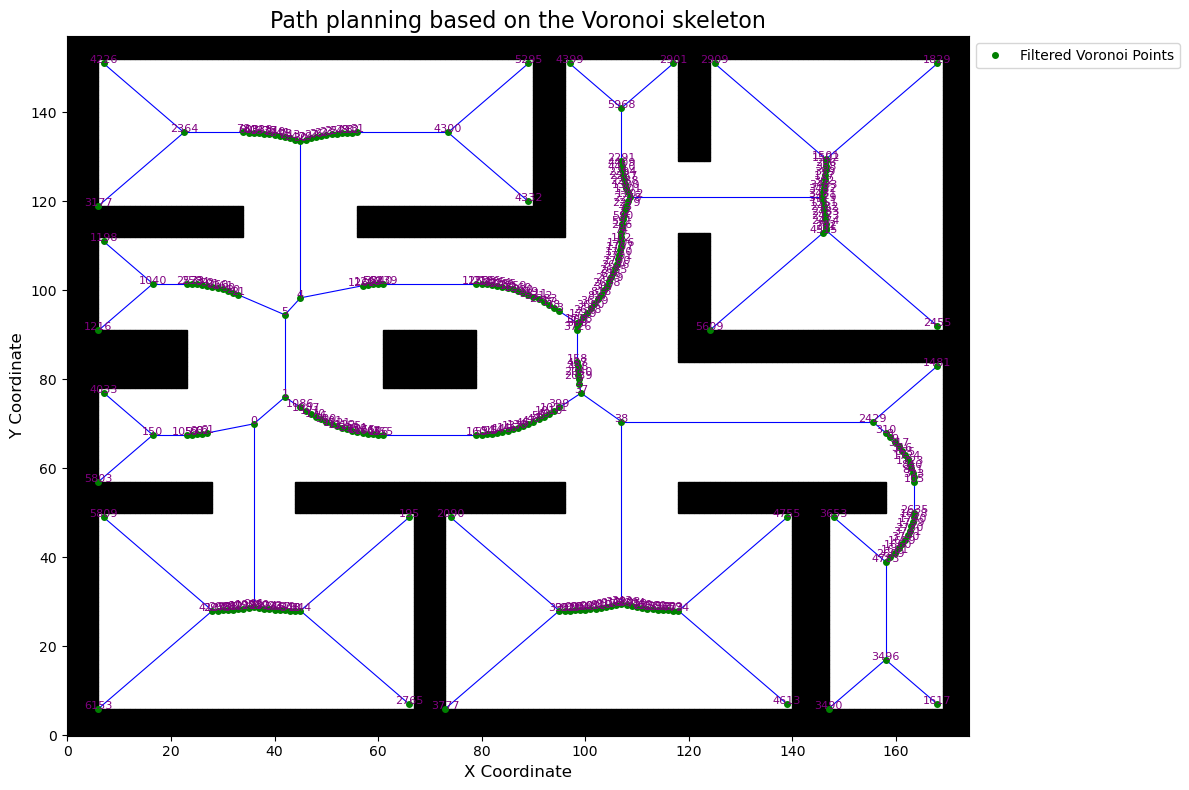

In [81]:
plot(vor,pruned_vertices,final1_adjacency_matrix,final_map,show=True)

In [ ]:
from queue import PriorityQueue
def astar_path(start, goal, pruned_vertices, adjacency_matrix):
    path = []
    open_set = PriorityQueue()
    open_set.put((0, start))
    came_from = {start: None}
    g_score = {v: float('inf') for v in range(len(pruned_vertices))}
    g_score[start] = 0
    f_score = {v: float('inf') for v in range(len(pruned_vertices))}
    f_score[start] = np.linalg.norm(pruned_vertices[start] - pruned_vertices[goal])

    closed_set = set()  # Initialize closed set

    while not open_set.empty():
        _, current = open_set.get()
        if current == goal:
            # Backtrack path
            while current is not None:
                path.append(current)
                current = came_from[current]
            path.reverse()
            return path

        closed_set.add(current)  # Add current node to closed set

        for neighbor, distance in enumerate(adjacency_matrix[current]):
            if distance > 0 and neighbor not in closed_set:  # Only process neighbors not in closed set
                tentative_g_score = g_score[current] + distance
                if tentative_g_score < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g_score
                    f_score[neighbor] = tentative_g_score + np.linalg.norm(pruned_vertices[neighbor] - pruned_vertices[goal])
                    open_set.put((f_score[neighbor], neighbor))

    return path

In [ ]:
def extract_key_points1(Apath, grid_map, dth, pruned_vertices, vor):
    tpath = []  # Initialize key vertex path
    i = 0
    tpath.append(Apath[i])  # Add starting point to tpath

    while i < len(Apath) - 1:
        # Get coordinates of the last key node (tpath[-1]) and current node to check jv
        S_index = pruned_vertices[tpath[-1]]
        S = vor.vertices[S_index]

        j = i + 1
        while j < len(Apath):
            # Get coordinates of the next node to check jv
            jv_index = pruned_vertices[Apath[j]]
            jv = vor.vertices[jv_index]

            # Step (3): Check if there are obstacles between last key node S and jv
            min_x, max_x = int(min(S[0], jv[0])), int(max(S[0], jv[0]))
            min_y, max_y = int(min(S[1], jv[1])), int(max(S[1], jv[1]))

            obstacle_found = False
            for x in range(min_x, max_x + 1):
                for y in range(min_y, max_y + 1):
                    if grid_map[x, y] == 1:  # Obstacle grid
                        obstacle_found = True
                        break
                if obstacle_found:
                    break

            # If no obstacles between last key node and jv, continue pruning redundant nodes
            if not obstacle_found:
                j += 1
            else:
                # Step (4): If obstacles exist, calculate minimum distance dmin between path and obstacles
                dmin = float('inf')
                for x in range(min_x, max_x + 1):
                    for y in range(min_y, max_y + 1):
                        if grid_map[x, y] == 1:
                            # Calculate minimum distance from obstacle center to path
                            p_i = np.array([x + 0.5, y + 0.5])  # Obstacle center coordinates
                            distance_to_path = np.abs(np.linalg.det([jv - S, p_i - S]) / np.linalg.norm(jv - S))
                            dmin = min(dmin, distance_to_path)

                # Check if dmin is less than threshold dth
                if dmin > dth:
                    # Obstacle is far enough from path, continue pruning redundant nodes
                    j += 1
                else:
                    # Obstacle is close to path, add node j-1 as key node to tpath
                    tpath.append(Apath[j - 1])
                    i = j - 1  # Update i to new key node position
                    break

        # Update starting point to last key node
        i = j

    # Add endpoint to tpath
    tpath.append(Apath[-1])
    return tpath

In [ ]:
def extract_key_points(Apath, grid_map, dth, pruned_vertices, vor):
    tpath = []  # Initialize key vertex path
    i = 0
    tpath.append(Apath[i])  # Add starting point to tpath

    while i < len(Apath) - 1:
        # Get coordinates of the last key node (tpath[-1]) and current node to check jv
        S_index = pruned_vertices[tpath[-1]]
        S = vor.vertices[S_index]

        j = i + 1
        while j < len(Apath):
            # Get coordinates of the next node to check jv
            jv_index = pruned_vertices[Apath[j]]
            jv = vor.vertices[jv_index]

            # Check if there are obstacles on the path
            min_x, max_x = int(min(S[0], jv[0])), int(max(S[0], jv[0]))
            min_y, max_y = int(min(S[1], jv[1])), int(max(S[1], jv[1]))

            # Initialize variables to detect if path meets obstacle-free and minimum distance requirements
            no_obstacle_found = True
            min_distance_to_obstacle = float('inf')

            # Traverse all grids on the path to detect obstacles
            for x in range(min_x, max_x + 1):
                for y in range(min_y, max_y + 1):
                    if 0 <= x < grid_map.shape[0] and 0 <= y < grid_map.shape[1]:  # Prevent out of bounds
                        if grid_map[x, y] == 1:  # Current grid is an obstacle
                            no_obstacle_found = False
                            break
                if not no_obstacle_found:
                    break

            # If obstacles exist on the path, stop current path segment check
            if not no_obstacle_found:
                tpath.append(Apath[j - 1])  # Extract key point of current path segment
                i = j - 1
                break

            # Check shortest distance between path and surrounding obstacles
            for x in range(min_x - 3, max_x + 3):  # Extend range by one grid
                for y in range(min_y - 3, max_y + 3):  # Extend range by one grid
                    if 0 <= x < grid_map.shape[0] and 0 <= y < grid_map.shape[1]:  # Prevent out of bounds
                        if grid_map[x, y] == 1:  # Current grid is an obstacle
                            # Calculate shortest distance from obstacle to path
                            p_i = np.array([x + 0.5, y + 0.5])  # Obstacle center point coordinates
                            distance_to_path = np.abs(np.linalg.det([jv - S, p_i - S]) / np.linalg.norm(jv - S))
                            min_distance_to_obstacle = min(min_distance_to_obstacle, distance_to_path)

            # If shortest distance between path and nearby obstacles is less than threshold, stop current path segment check
            if min_distance_to_obstacle < dth:
                tpath.append(Apath[j - 1])  # Extract key point of current path segment
                i = j - 1
                break

            # If path meets all conditions, continue checking next node
            j += 1

        # Update starting point to last key node
        i = j

    # Add endpoint to tpath
    tpath.append(Apath[-1])
    return tpath


In [ ]:
start_p = 3496  # Starting point index in pruned_vertices
goal_p = 2364  # Goal point index in pruned_vertices
dth = 3  # Distance threshold

start = [v for k, v in final_map.items() if k == start_p][0]
goal = [v for k, v in final_map.items() if k == goal_p][0]
# Execute A* algorithm to obtain initial path
Apath = astar_path(start, goal, pruned_vertices, final1_adjacency_matrix)
true_Apath = []
true_Tpath = []
for i in Apath: 
    point = [k for k, v in final_map.items() if v == i]
    #pruned_vertices[Apath[i]]
    true_Apath.append(point)
# Extract key vertices
tpath = extract_key_points(Apath, grid_map, dth, pruned_vertices, vor)
for i in tpath: 
    point = [k for k, v in final_map.items() if v == i]
    true_Tpath.append(point)

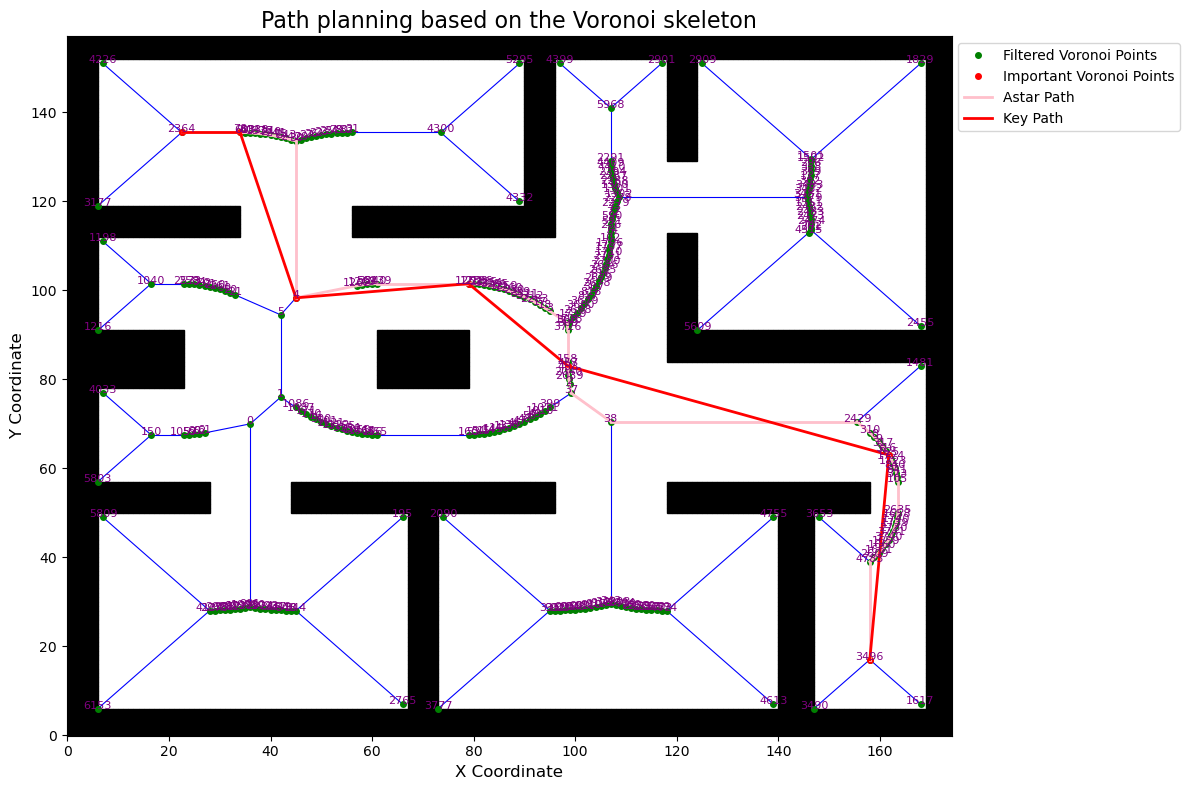

In [86]:
plot(vor,pruned_vertices,final1_adjacency_matrix,final_map,show = True,tpath=tpath,Apath=Apath , show_Ipath=True,show_Apath= True)

In [ ]:
row = np.size(grid_map, 0)  # Number of rows
col = np.size(grid_map, 1)  # Number of columns
grid_size = (int(row / resolution), int(col / resolution))  # Grid map size
resolution = 1  # Each grid represents one unit

In [88]:
print(row,col)

157 174


In [89]:
true_Tpath
flat_list = np.array(true_Tpath).flatten().tolist()
print(true_Tpath)
print(flat_list)

[[3496], [825], [457], [1252], [4], [78], [2364]]
[3496, 825, 457, 1252, 4, 78, 2364]


In [ ]:
key_path_edges = []
for i in range(0, len(tpath) - 1):
    key_path_edges.append((flat_list[i], flat_list[i + 1]))
print(key_path_edges)
len(key_path_edges)

[(3496, 825), (825, 457), (457, 1252), (1252, 4), (4, 78), (78, 2364)]


6

In [91]:
important_v = []

for i in range(0, len(tpath)):
    coord = vor.vertices[true_Tpath[i]]
    coord_flat = np.array(coord).reshape(-1)
    coord_int = tuple(int(v) for v in coord_flat)
    important_v.append(coord_int)

print(important_v)
np.save("data.npy", important_v)
len(important_v)

[(17, 158), (63, 161), (83, 98), (101, 79), (98, 45), (135, 34), (135, 22)]


7

In [ ]:
def bresenham_line(x1, y1, x2, y2):
    """
    Generate grid coordinates of a line using Bresenham's algorithm.

    Args:
        x1, y1: Starting point coordinates.
        x2, y2: Ending point coordinates.

    Returns:
        rr, cc: List of grid row and column coordinates that the line passes through.
    """
    rr, cc = [], []
    dx, dy = abs(x2 - x1), abs(y2 - y1)
    sx, sy = (1 if x1 < x2 else -1), (1 if y1 < y2 else -1)
    err = dx - dy

    while True:
        rr.append(x1)
        cc.append(y1)
        if x1 == x2 and y1 == y2:
            break
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return rr, cc

In [ ]:
def plot_to_grid(vor, key_path_edges, obstacles, grid_size, resolution):
    # Initialize grid map, default all to passable area (0)
    grid_map = np.zeros(grid_size, dtype=int)

    # Draw obstacles on grid map
    for obstacle in obstacles:
        x, y = (np.array(obstacle) / resolution).astype(int)
        if 0 <= x < grid_size[0] and 0 <= y < grid_size[1]:  # Prevent out of bounds
            grid_map[x, y] = 1  # Mark obstacle as 1

    # Draw skeleton key path on grid map
    for edge in key_path_edges:
        start_index, end_index = edge
        start = vor.vertices[start_index]
        end = vor.vertices[end_index]
        
        # Map path points from actual coordinates to grid coordinates
        x1, y1 = (start / resolution).astype(int)
        x2, y2 = (end / resolution).astype(int)
        
        # Use Bresenham's algorithm to draw line segments on grid
        rr, cc = bresenham_line(x1, y1, x2, y2)
        for r, c in zip(rr, cc):
            if 0 <= r < grid_size[0] and 0 <= c < grid_size[1]:  # Prevent out of bounds
                if grid_map[r, c] != 1:  # Avoid overwriting obstacles
                    grid_map[r, c] = 2  # Mark key path as 2

    return grid_map

In [94]:

grid_map_final = plot_to_grid(vor,key_path_edges,obstacle_points,grid_size,resolution)
np.savetxt("grid_map_final2.txt", grid_map_final, fmt="%d", delimiter=" ")

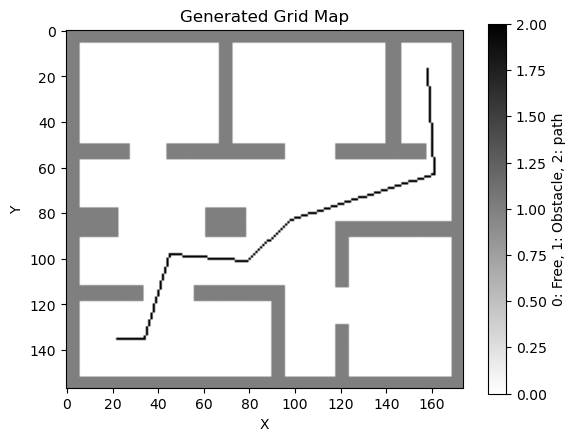

In [95]:
import matplotlib.pyplot as plt

plt.imshow(grid_map_final, cmap='gray_r')
plt.title("Generated Grid Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(label="0: Free, 1: Obstacle, 2: path")
plt.show()